In [1]:
from plotnine import *
import pandas as pd
import numpy as np

In [12]:
# time = "2024-03-29_04:53"
time = "2024-03-29_07:23"
time = "2024-03-31_15:54"
time = "2024-03-31_16:37"
time = "2024-03-31_17:12"
time = "2024-04-01_15:42"
time = "2024-04-01_17:06"
time = "2024-04-01_18:11"
time = "2024-04-16_16:47"
time = "2024-04-18_19:23"
time = "2024-04-18_20:30"
time = "2024-04-19_01:29"
time = "2024-04-19_09:39"
time = "2024-05-19_16:34"
time = "2024-05-19_16:58"
time = "2024-05-19_17:38"
time = "2024-05-19_18:55"
time = "2024-05-20_04:15"
time = "2024-05-20_10:30"
time = "2024-05-29_13:27"
time = "2024-06-10_12:52"
time = "2024-06-10_19:47"
time = "2024-06-10_22:59" # USD_JPY_M15
time = "2024-06-11_04:01" # USD_CHF_M15
# time = "2024-06-11_04:14" # USD_CAD_M15

df = pd.read_csv(f"/projects/genomic-ml/da2343/ml_project_2/unsupervised/kmeans/results/{time}_results.csv")

# df['test_cumsum_annualized_return'] = df['test_cumsum_annualized_return'] * -1
# remove where dist_measure is 2
# remove where future_candles is 5
# remove where n_clusters is 150 or 200
# remove where log_return_threshold is greater than 0.01
# remove where calmar_ratio_threshold is not 2

# df = df[df["dist_measure"] != 2]
# df = df[df["window"] < 5]
# df = df[df["random_state"] == 42]
# df = df[df["test_size"] == 2880]
# df = df[df["algorithm"] == "kmeans"]
# df = df[(df["test_negative_sharpe_ratio"] >= 1) | (df["test_sharpe_ratio"] >= 1)]
df = df[(df["test_negative_sharpe_ratio"] >= 0.2) | (df["test_sharpe_ratio"] >= 0.2)]

# df = df[(df["algorithm"] == 'gaussian_mixture')]
# df = df[(df["max_k_labels"] == 1)]
# df = df[(df["random_state"] == 200)]

df

,window,train_sum_annualized_return,train_sum_actual_return,train_n_trades,test_sum_annualized_return,test_sum_actual_return,test_n_trades,train_cumsum_annualized_return,train_cumsum_actual_return,train_sharpe_ratio,test_cumsum_annualized_return,test_cumsum_actual_return,test_sharpe_ratio,test_negative_sharpe_ratio,max_k_labels,n_clusters,algorithm,train_size,test_size,random_state
46940,0,0.48,48,76,-0.02,-2,12,0.48,48,4.124333,-0.02,-2,-0.357620,0.202672,2,120,gaussian_mixture,3840,960,50
46941,1,0.58,58,107,-0.09,-9,35,1.06,106,4.124333,-0.11,-11,-0.357620,0.202672,2,120,gaussian_mixture,3840,960,50
46942,2,0.68,68,112,-0.07,-7,29,1.74,174,4.124333,-0.18,-18,-0.357620,0.202672,2,120,gaussian_mixture,3840,960,50
46943,3,0.51,51,101,-0.38,-38,56,2.25,225,4.124333,-0.56,-56,-0.357620,0.202672,2,120,gaussian_mixture,3840,960,50
46944,4,1.11,111,151,-0.14,-14,30,3.36,336,4.124333,-0.70,-70,-0.357620,0.202672,2,120,gaussian_mixture,3840,960,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525833,120,1.54,154,346,0.21,21,41,201.73,20173,3.778486,-10.72,-1072,-0.262093,0.205461,5,90,gaussian_mixture,3840,960,50
525834,121,1.64,164,384,-0.38,-38,74,203.37,20337,3.778486,-11.10,-1110,-0.262093,0.205461,5,90,gaussian_mixture,3840,960,50
525835,122,1.03,103,188,0.05,5,31,204.40,20440,3.778486,-11.05,-1105,-0.262093,0.205461,5,90,gaussian_mixture,3840,960,50
525836,123,2.04,204,366,0.16,16,80,206.44,20644,3.778486,-10.89,-1089,-0.262093,0.205461,5,90,gaussian_mixture,3840,960,50


/projects/genomic-ml/da2343/cs685/lib/python3.9/site-packages/plotnine/facets/facet.py:446: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'


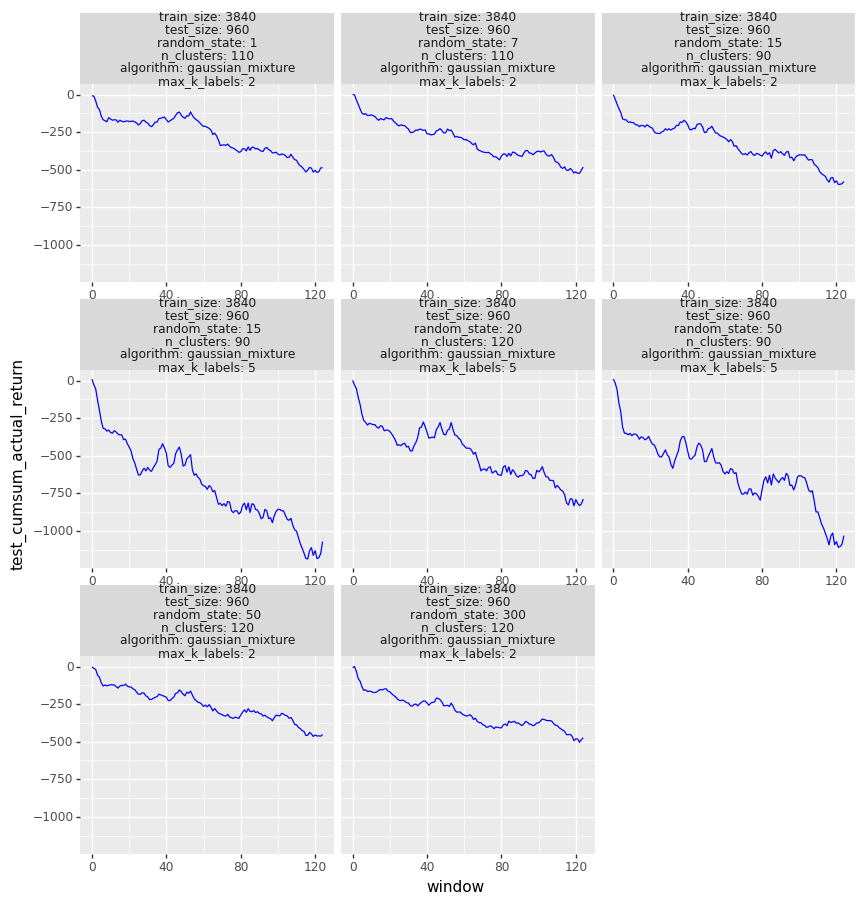

In [13]:
p = ggplot(df)
# p = p + geom_line(aes(x="window", y="train_cumsum_annualized_return"), color="red")
p = p + geom_line(aes(x="window", y="test_cumsum_actual_return"), color="blue")
# p = p + geom_line(aes(x="window", y="val_avg_calmar_ratio"), color="red")
# p = p + facet_wrap("~train_size + random_state", scales="free_x", labeller="label_both")
p = p + facet_wrap("~train_size + test_size + random_state + n_clusters + algorithm + max_k_labels", scales="free_x", labeller="label_both")
# p = p + theme(figure_size=(35, 35))
p = p + theme(figure_size=(10, 10))
print(p)

In [ ]:

time = "2024-03-14_19:00"
df = pd.read_csv(f"/projects/genomic-ml/da2343/ml_project_2/kmeans/results/{time}_results.csv")

p = ggplot(df)
p = p + geom_line(aes(x="window", y="test_cumsum_annualized_return"), color="blue")
# p = p + geom_line(aes(x="window", y="val_cumsum_annualized_return"), color="red")
p = p + facet_wrap("~train_size + test_size + random_state", scales="free_x", labeller="label_both")
p = p + theme(axis_text_x=element_text(angle=90), figure_size=(30, 30))
print(p)